# Homework 3
Lauren Bassett  
DS 6040

Honor Pledge: On my honor, I pledge that I have neither given nor recieved help on this assignment. 

## Part 1: Changepoint detection and samplers (50 points)

1. (50 points) With the above information, complete the Gibbs sampler in the accompanying notebook.
You should only need to complete the update steps for the µ and λ (called lambdap in the notebook)
parameters. Run the Gibbs sampler, plot the posterior densities and calculate the EAP estimates with
95% (equal tailed) credible intervals for µ and λ. Provide the top 5 most probable values of k.


In [1]:
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

,Year,Count
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0


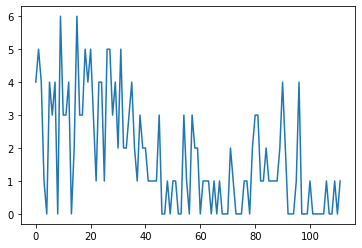

In [2]:
#Import dataset
coal_dat = pd.read_csv("coaldisasters-ds6040.csv")
coal_dat['Count'].plot()
coal_dat.head()

In [53]:
def log_like(x_data, mu, lamb, k):
    n = len(x_data)
    first_chunks = poisson.logpmf(x_data[0:k], mu) 
    second_chunks = poisson.logpmf(x_data[(k):n], lamb)
    return np.sum(first_chunks) + np.sum(second_chunks)

# example call
log_like(np.random.choice(4, size=3), 1, 2, 3)

-4.386294361119891

In [54]:
# example sampling from a gamma
# make sure you use the correct arguments
rate = 10
gamma.rvs(2, scale = 1/rate)

0.3834648465811179

In [55]:
def samp_k(x_data, mu, lamb):
    n = len(x_data)
    possible_ks = np.arange(n)
    
    log_unnorm_weights = [log_like(x_data, mu, lamb, k) for k in possible_ks] #get array of loglikelihood for each possible k
 
    log_denominator = logsumexp(log_unnorm_weights)
    log_norm_weights = log_unnorm_weights - log_denominator

    return np.random.choice(n, size=1, p=np.exp(log_norm_weights))[0]

samp_k(coal_dat['Count'], 2, 2)

2

In [56]:
class CoalDisasterModel():
    """Gibbs Sampler"""
    def __init__(self, data, a_mu, b_mu, a_lambda, b_lambda, 
                 start_mu = 5, start_lambda = .1, start_k = 64, iter_num = 1000, burnin = 500):
        
        #Read in data and priors, and make them contained class variables
        self.data = data
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.a_lambda = a_lambda
        self.b_lambda = b_lambda
        self.iter_num = iter_num
        self.burnin = burnin
        
        #Initalize sampling containers
        self.mu = np.zeros(iter_num+burnin+1)
        self.lambdap = np.zeros(iter_num+burnin+1)
        self.k = np.zeros(iter_num+burnin+1)
        
        #Put in starting values
        self.mu[0] = start_mu
        self.lambdap[0] = start_lambda
        self.k[0] = start_k     
        
        for i in np.arange(iter_num+burnin):
            if i % 100 == 0:
                print("Iteration " + str(i))
            
            
            #This is where you modify the sampler
            self.mu[i+1] =  gamma.rvs(a_mu+sum(data[:int(self.k[i])]),scale=1/(self.k[i]+b_mu))
            self.lambdap[i+1] = gamma.rvs(a_lambda + sum(data[int(self.k[i]):]),scale=1/( len(data)- self.k[i]+b_lambda))
            self.k[i+1] = samp_k(self.data, self.mu[i+1], self.lambdap[i+1])
            
    def plot_posteriors(self):
        f, axs = plt.subplots(3,2, figsize = (15, 7))
        f.tight_layout(pad = 3)
        sns.kdeplot(self.mu[self.burnin:],ax =axs[0,0])
        axs[0,0].set_xlabel(r'Posterior $\mu$')
        axs[0,0].set_ylabel('Probability Density')
        sns.kdeplot(self.lambdap[self.burnin:], ax =axs[1,0])
        axs[1,0].set_xlabel(r'Posterior $\lambda$')
        axs[1,0].set_ylabel('Probability Density')
        axs[2,0].hist(self.k[self.burnin:], bins = 112)
        axs[2,0].set_xlabel(r'Posterior k')
        axs[2,0].set_ylabel('Frequency')
        axs[0,1].plot(np.arange(self.iter_num+self.burnin+1),self.mu, '-')
        axs[0,1].set_xlabel('')
        axs[0,1].set_ylabel(r'Posterior $\mu$')
        axs[1,1].plot(np.arange(self.iter_num+self.burnin+1),self.lambdap,'-')
        axs[1,1].set_xlabel('')
        axs[1,1].set_ylabel(r'Posterior $\lambda$')
        axs[2,1].plot(np.arange(self.iter_num+self.burnin+1),self.k,'-')
        axs[2,1].set_xlabel('Iteration')
        axs[2,1].set_ylabel('Posterior k')
    
    def get_rate_estimates(self):
        to_return =pd.DataFrame(columns = ['Posterior EAP', 'Posterior Cred Interval Lower', 'Posterior Cred Interval Upper'])
        to_return.loc[r'mu', 'Posterior EAP'] = self.mu[self.burnin:].mean()
        to_return.loc[r'lambda', 'Posterior EAP'] = self.lambdap[self.burnin:].mean()
        to_return.loc[r'mu', 'Posterior Cred Interval Lower'] = np.quantile(self.mu[self.burnin:],.025)
        to_return.loc[r'lambda', 'Posterior Cred Interval Lower'] = np.quantile(self.lambdap[self.burnin:],.025)
        to_return.loc[r'mu', 'Posterior Cred Interval Upper'] = np.quantile(self.mu[self.burnin:],.975)
        to_return.loc[r'lambda', 'Posterior Cred Interval Upper'] = np.quantile(self.lambdap[self.burnin:],.975)
        return to_return
    
    def get_k_probs(self):
        freq = np.bincount(abs(self.k.astype('int'))[self.burnin:])
        ii = np.nonzero(freq)[0]
        freq = np.vstack((ii,freq[ii])).T
        freq = freq.astype("float16")
        freq[:,1] = freq[:,1]/(freq[:,1].sum())
        freq = pd.DataFrame(freq, columns=['k', 'Probability of k'])
        
        return freq

In [62]:
test = CoalDisasterModel(coal_dat['Count'], 1,1,1,1)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400


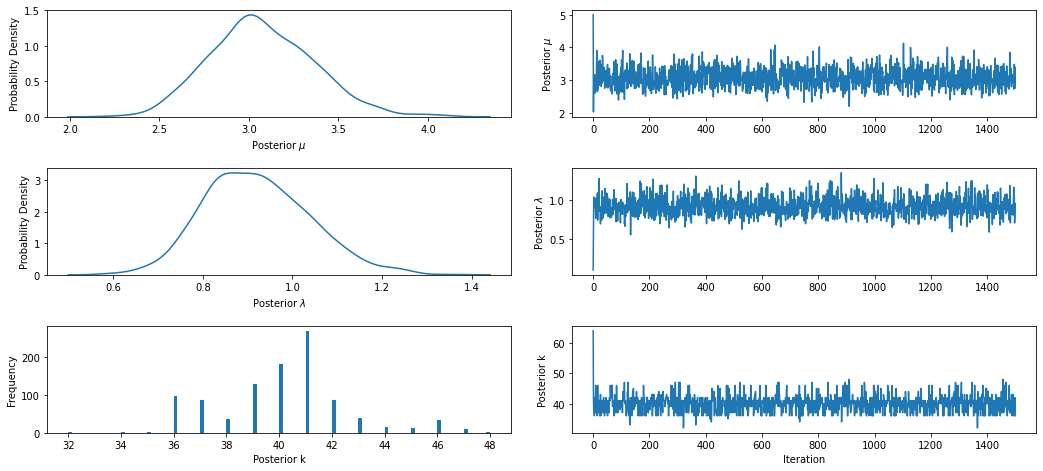

In [63]:
test.plot_posteriors()

In [64]:
test.get_rate_estimates()

,Posterior EAP,Posterior Cred Interval Lower,Posterior Cred Interval Upper
mu,3.074465,2.561465,3.683281
lambda,0.920704,0.715105,1.166181


In [65]:
most_probable = test.get_k_probs()
most_probable.sort_values(by=["Probability of k"], ascending=False).head(5)

,k,Probability of k
8,41.0,0.267822
7,40.0,0.179810
6,39.0,0.127930
3,36.0,0.095886
9,42.0,0.086914


In [67]:
most_probable['year'] =[int(y+1851) for y in most_probable['k']]
most_probable.sort_values(by=["Probability of k"], ascending=False).head(5)

,k,Probability of k,year
8,41.0,0.267822,1892
7,40.0,0.179810,1891
6,39.0,0.127930,1890
3,36.0,0.095886,1887
9,42.0,0.086914,1893


Then do the the following:


a) Describe your findings. What do these EAP and credible intervals imply? And what was the most likely year of the changepoint?  

The posterior distributions show that the most likely date for the changepoint is centered around 40 (1892). The data is clearly on either side of this break, which mirrors what we see in the original plot. 
The EAP is the expected value of changepoint, and the credible interval is the range of dates most likely to be the changepoint. 


The year most likely to be the changepoint is 1892.

b) Why is an EAP or credible interval not neccesarily the most appropriate thing to report for the year of the changepoint?

The EAP is the expected value, and in this case, it might not be the most appropriate measure since we are interested in the overall shape of the distribution, and when things began to change. 

For this reason, the credible interval is probably more appropriate, however, if we wanted a basis for a single point in time, the EAP would be better to report the year of the changepoint. 

## Part 2: Bayesian Logisitic Regression with PyMC3

### 1. Load the data ansd create a new binary variable where the new quality of the wine is 0 if the wine recieved a C or an F, and a 1 if the wine recieved an A.

In [70]:
wine = pd.read_csv('whitewine-training-ds6040.csv')

In [71]:
wine['quality_binary'] = [1 if x == "A" else 0 for x in wine['wine_quality']]

In [83]:
overall_best_classification = "wine['wine_quality']~ wine['volatile.acidity'] + wine['residual.sugar'] + wine['alcohol']"
overall_best_A = "wine['wine_quality'] ~ wine['fixed.acidity']+wine['free.sulfur.dioxide']+wine['alcohol']"

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
The installed Theano(-PyMC) version (1.0.5) does not match the PyMC3 requirements.
It was imported from ['C:\\Users\\laure\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python38\\site-packages\\theano']
For PyMC3 to work, a compatible Theano-PyMC backend version must be installed.
See https://github.com/pymc-devs/pymc3/wiki for installation instructions.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


AttributeError: 'TheanoConfigParser' object has no attribute 'gcc__cxxflags'

In [84]:
###The following code is heavily based or taken directly from: https://www.kaggle.com/billbasener/pymc3-bayesian-logistic-regression-classification

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
        


In [94]:
wine.columns = wine.columns.str.replace(".", "_", regex=False)
wine_best = wine[['volatile_acidity', 'residual_sugar', 'alcohol', 'quality_binary']]

In [95]:

#This is the general form for the logistic. You will need to change the model formula to match the white wine data.
with pm.Model() as model:
    pm.glm.GLM.from_formula(formula = "quality_binary ~ volatile_acidity + residual_sugar + alcohol", 
                            data = wine_best, 
                            family = pm.glm.families.Binomial())

    trace = pm.sample(1000)


#You can obtain forest plots with:
pm.plots.forestplot(trace, figsize = (12,5))

#You can get a table of summary statistics out using:
pm.summary(trace)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local

ValueError: Not enough samples to build a trace.